# Overview

This notebook is a submission for the take-home test as part of the hiring process for the AI Engineer Internship at Adamata. The primary objective of the test is to develop a multiclass classification model capable of categorizing images into one of six classes: cardboard, glass, metal, paper, plastic, or trash.

This notebook consists of the following sections:

1. **Exploratory Data Analysis**: Analyze the dataset to understand its structure, distribution, and characteristics.
2. **Setup WandB**: Configure the WandB tool for experiment tracking and logging.
3. **Prepare Dataset**: Process and organize the dataset for training, validation, and testing.
4. **Model Selection**: Choose a suitable model architecture for the classification task.
5. **Hyperparameter Tuning**: Optimize model performance by fine-tuning hyperparameters.
6. **Evaluation on Test Set**: Assess the model's performance on unseen test data.
7. **Evaluation Analysis**: Analyze the evaluation results to identify strengths and weaknesses.

# Exploratory Data Analysis

Since this is an image classification task, there isn't much to explore in the EDA stage, except for checking whether the classes are balanced or not. First, we will load the dataset from Hugging Face and visualize the distribution of classes.

## Load Dataset

In [ ]:
from datasets import load_dataset

dataset_path = "garythung/trashnet"

original_dataset = load_dataset(dataset_path, split="train")

## Classes Distribution

In [2]:
# map id class to real name
id2label = {
    0: "cardboard",
    1: "glass",
    2: "metal",
    3: "paper",
    4: "plastic",
    5: "trash"
}

label2id = {v: k for k, v in id2label.items()}

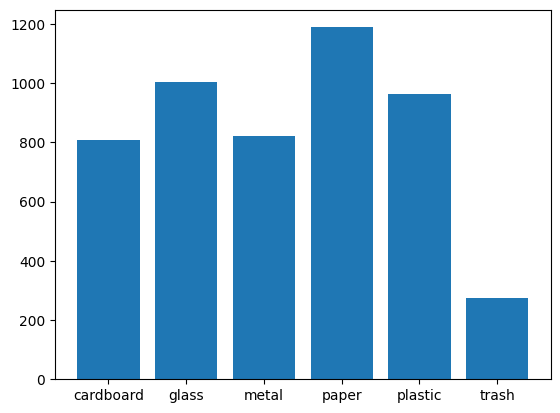

In [3]:
import matplotlib.pyplot as plt

count_labels = {
    k: original_dataset["label"].count(v) for k, v in label2id.items()
}

plt.bar(
    x=count_labels.keys(),
    height=count_labels.values()
)

plt.show()

As we can see, the dataset is imbalanced. The class with the lowest number of samples is "trash" consist around 300 samples, while the class with the highest representation is "paper" around 1,100 samples. To address this imbalance, we will assign weights to each class, giving higher weights to classes with fewer samples and lower weights to classes with more samples. These class weights will be used during the calculation of the loss function in the training stage, ensuring the model focuses more on lowest classes.

In [4]:
import torch
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

device = "cuda" if torch.cuda.is_available() else "cpu"

class_weight = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(original_dataset["label"]),
    y=original_dataset["label"]
)
class_weight = torch.tensor(class_weight, dtype=torch.float).to(device)

print(class_weight)

tensor([1.0451, 0.8407, 1.0272, 0.7090, 0.8738, 3.0742])


## Check Image Size

In [5]:
print(original_dataset[:10])

{'image': [<PIL.Image.Image image mode=RGB size=3024x4032 at 0x7BBE5447B310>, <PIL.Image.Image image mode=RGB size=3024x4032 at 0x7BBE5447BA60>, <PIL.Image.Image image mode=RGB size=4032x3024 at 0x7BBE53C13F40>, <PIL.Image.Image image mode=RGB size=3024x4032 at 0x7BBE53C601F0>, <PIL.Image.Image image mode=RGB size=3024x4032 at 0x7BBE53E35F30>, <PIL.Image.Image image mode=RGB size=4032x3024 at 0x7BBE539914E0>, <PIL.Image.Image image mode=RGB size=3024x4032 at 0x7BBE53991600>, <PIL.Image.Image image mode=RGB size=4032x3024 at 0x7BBE53224970>, <PIL.Image.Image image mode=RGB size=4032x3024 at 0x7BBE52F5EB00>, <PIL.Image.Image image mode=RGB size=4032x3024 at 0x7BBE5491FE80>], 'label': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [9]:
from PIL import Image
import os
from tqdm import tqdm

def preprocess_images(output_dir, size=(512, 512)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for i, data in enumerate(tqdm(original_dataset)):
        output_path = os.path.join(output_dir, f"{i}.png")
        data["image"].thumbnail(size, Image.Resampling.LANCZOS)
        data["image"].save(output_path)
        
preprocess_images("./preprocessed_images")

100%|██████████| 5054/5054 [22:36<00:00,  3.73it/s]


# Setup WandB

In this section, we will configure WandB to track our experiments and monitor model performance. We will log in to our WandB account using the API key generated by the account. During the model selection and hyperparameter tuning stages, we will use WandB to track the training process, including metadata of the model and metric evaluation.

In [10]:
%%capture
import wandb
from dotenv import load_dotenv
import os
# from kaggle_secrets import UserSecretsClient

# wandb_api_key = UserSecretsClient().get_secret("WANDB_API_KEY")
load_dotenv()
wandb_api_key = os.getenv("WANDB_API_KEY")
wandb.login(key=wandb_api_key)

project_name = "adamata-takehome-test"

In [11]:
from datetime import datetime
import pytz

# function to generate name for wandb run, e.g. model-selection-ResNet50-20242911223030
def generate_run_name(prefix=""):
    utc = pytz.utc
    utc_datetime = utc.localize(datetime.today())
    
    local_timezone = pytz.timezone("Asia/Jakarta")
    local_datetime = utc_datetime.astimezone(local_timezone)
    
    return f"{prefix}-{local_datetime.strftime('%Y%m%d%H%M%S')}"

# Prepare Dataset

In this section, we will prepare the dataset for the image classification task by ensuring the images are preprocessed to fit the model's input requirements. The preprocessing steps will be implemented using a custom `collate_fn` function to ensures that the data is properly formatted and ready for training stage.

## Create CollateFn

There are two `collate_fn`, one for the training set and the other for the validation and test sets. Both collate_fn functions perform essential preprocessing steps, including resizing, cropping, converting images to tensors, and normalizing the pixel values.

For the training set, additional data augmentation techniques are applied, such as random resizing and cropping, random flipping, and random rotation. These augmentations introduce variation into the training data, helping the model generalize better.

In [12]:
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, path, labels):
        self.path = path
        self.labels = labels

    def __getitem__(self, idx):
        img_path = os.path.join(self.path, f"{idx}.png")
        label = self.labels[idx]

        return {"image": Image.open(img_path), "label": label}

    def __len__(self):
        return len(self.labels)

dataset = CustomDataset(
    "/kaggle/working/preprocessed_images",
    original_dataset["label"]
)

In [13]:
from torchvision.transforms import v2

train_transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = v2.Compose([
    v2.ToImage(),
    v2.CenterCrop(size=(224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class CollateFn(object):
    def __init__(self, transforms, image_size):
        self.transforms = transforms
        self.image_size = image_size
        # self.batch_size = batch_size
    
    def __call__(self, batch):
        # images = torch.zeros(self.batch_size, 3, self.image_size[0], self.image_size[1])
        # labels = torch.zeros(self.batch_size, dtype=torch.long)
        images = []
        labels = []
        
        for i, sample in enumerate(batch):
            # images[i, :] = train_transforms(sample["image"])
            # labels[i] = sample["label"]
            images.append(self.transforms(sample["image"]).unsqueeze(0))
            labels.append(torch.tensor([sample["label"]]))

        images = torch.concatenate(images)
        labels = torch.concatenate(labels)
    
        return images.to(device), labels.to(device)

# Model Selection

In this section, we will select an appropriate model architecture for the image classification task. There are a lot pre-trained model for the image classification task, so we will be use method called **transfer learning** instead made it from scratch. Transfer learning is a method to leverage knowledge from a pre-trained model to enhance performance on a related task. We will experiment with the following architectures:

1. **MobileNetV3 Large**: A lightweight CNN model, which ideal for mobile and embedded devices.
2. **ResNet50**: A CNN model with residual connections, which helps mitigate the vanishing gradient problem.

We will evaluate these models and choose the best model based on their evaluation metrics on validation set.

## Evaluation Metrics

Since the dataset is imbalanced, we will use the F1 score as an additional evaluation metric. This metric takes both precision and recall into account that will help to ensure that the model is not biased toward the majority class and performs well across all classes.

In [14]:
import torch.nn.functional as F
from sklearn.metrics import f1_score

def accuracy(logits, labels):
    pred = F.softmax(logits, dim=1).argmax(dim=1)
    
    return float(torch.mean((pred == labels).float()))

def calculate_f1_score(logits, labels):
    pred = F.softmax(logits, dim=1).argmax(dim=1)

    return f1_score(labels.cpu(), pred.cpu(), average="weighted")

## Trainer Class

In order to train the model, we will implement a `Trainer` class, which encapsulates the training logic for the model as an object. This class provides several methods, including:

1. `train_model`: Handles the training process for the model.
2. `eval_model`: Evaluates the model's performance on validation or test datasets.
3. `get_split_indices`: Retrieves indices for splitting the dataset from the WandB project artifacts if exist, otherwise it will generate and save them to the artifact. This will ensure the dataset will be deterministic across the training stage every time we run the notebook.

During initialization, the Trainer class will:
1. Set up WandB: Configure WandB for experiment tracking.
2. Handle dataset splits: The indices will retrieved from `get_split_indices` method. These indices will be used to split the dataset into training, validation, and test sets.
3. Create data loaders: The datasets will be converted into data loaders using the appropriate collate_fn functions defined earlier for preprocessing.
4. Additionally, custom metrics will be defined in WandB to adjust the x-axis display:
    - Step: Used for tracking training loss at each step.
    - Epoch: Used for visualizing metrics such as training loss, validation loss, and other evaluation metrics.

In [15]:
import torch
from torch import nn
from torch.utils.data import Subset, DataLoader
import os
from sklearn.model_selection import train_test_split
import pandas as pd

image_size = (224, 224)
num_labels = len(id2label)

class Trainer:
    def __init__(
        self,
        wandb_run: wandb.sdk.wandb_run.Run,
        model: torch.nn.Module,
        dataset: torch.utils.data.Dataset,
        final_train: bool=False
    ):
        self.final_train = final_train
        
        # setup wandb
        self.run = wandb_run
        self.run_config = self.run.config

        # setup model
        self.model = model
        
        if self.run_config["optimizer"] == "adam":
            self.optimizer = torch.optim.Adam(
                params=self.model.parameters(),
                lr=self.run_config["lr"]
            )
        elif self.run_config["optimizer"] == "sgd":
            self.optimizer = torch.optim.SGD(
                params=self.model.parameters(),
                lr=self.run_config["lr"],
                momentum=0.9
            )
        
        # get split indices from the wandb artifact if exists
        self.get_split_indices(dataset)

        # prepare data preprocessing
        train_collate_fn = CollateFn(train_transforms, image_size)
        test_collate_fn = CollateFn(test_transforms, image_size)

        # create subset of the dataset from split indices
        if not self.final_train:
            self.train_set = Subset(dataset, self.train_indices)
            self.val_set = Subset(dataset, self.val_indices)
            self.test_set = Subset(dataset, self.test_indices)
        else:
            self.train_indices.extend(self.val_indices)
            self.train_set = Subset(dataset, self.train_indices)
            self.test_set = Subset(dataset, self.test_indices)

        # create dataloader
        self.train_loader = DataLoader(
            self.train_set,
            batch_size=self.run_config["batch_size"],
            collate_fn=train_collate_fn
        )

        self.test_loader = DataLoader(
            self.test_set,
            batch_size=self.run_config["batch_size"],
            collate_fn=test_collate_fn
        )

        if not self.final_train:
            self.val_loader = DataLoader(
                self.val_set,
                batch_size=self.run_config["batch_size"],
                collate_fn=test_collate_fn
            )

        # define custom evaluation metric wandb
        self.run.define_metric("steps")
        self.run.define_metric("train_step_loss", step_metric="steps")
        
        self.run.define_metric("epoch")
        self.run.define_metric("train_epoch_acc", step_metric="epoch")
        self.run.define_metric("train_epoch_f1", step_metric="epoch")
        self.run.define_metric("train_epoch_loss", step_metric="epoch")

        if not self.final_train:
            self.run.define_metric("val_epoch_acc", step_metric="epoch")
            self.run.define_metric("val_epoch_f1", step_metric="epoch")
            self.run.define_metric("val_epoch_loss", step_metric="epoch")
        else:
            self.run.define_metric("test_acc", step_metric="epoch")
            self.run.define_metric("test_f1", step_metric="epoch")
            self.run.define_metric("test_loss", step_metric="epoch")
    
    def train_model(
        self,
        log_every_n_steps: int,
        aliases: list,
        weight: torch.Tensor=None
    ):
        steps = 0
        train_step_loss = 0
        total_steps = self.run_config["epochs"] * len(self.train_loader)
        
        print(f"Start training model!\tTotal epochs: {self.run_config['epochs']}\tTotal steps: {total_steps}\t")
        
        for epoch in range(self.run_config["epochs"]):
            print(f"[Epoch {epoch}/{self.run_config['epochs']}] Training model...")
            self.model.train()
            train_epoch_loss = 0
            outputs = []
            targets = []
            for images, labels in self.train_loader:
                logits = self.model(images)
                loss = F.cross_entropy(logits, labels, weight)

                outputs.append(logits)
                targets.append(labels)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
    
                train_step_loss += loss.item()
                train_epoch_loss += loss.item()
                steps += 1
                
                if steps%log_every_n_steps == 0 and steps != 0:
                    self.run.log({
                        "train_step_loss": train_step_loss/log_every_n_steps,
                        "steps": steps
                    })
                    train_step_loss = 0

            outputs = torch.concatenate(outputs)
            targets = torch.concatenate(targets)
            
            train_epoch_acc = accuracy(outputs, targets)
            train_epoch_f1 = calculate_f1_score(outputs, targets)

            print(f"[Epoch {epoch}/{self.run_config['epochs']}] Evaluating model...")
            self.run.log({
                "train_epoch_loss": train_epoch_loss/len(self.train_loader),
                "train_epoch_acc": train_epoch_acc,
                "train_epoch_f1": train_epoch_f1,
                "epoch": epoch
            })

            if not self.final_train:
                val_epoch_loss, val_epoch_acc, val_epoch_f1, _, _ = self.eval_model(self.val_loader, weight) 
            
                self.run.log({
                    "val_epoch_loss": val_epoch_loss,
                    "val_epoch_acc": val_epoch_acc,
                    "val_epoch_f1": val_epoch_f1,
                    "epoch": epoch
                })
                
        if self.final_train:
            test_loss, test_acc, test_f1, preds, true_labels = self.eval_model(self.test_loader, weight)

            self.run.log({
                "test_loss": test_loss,
                "test_acc": test_acc,
                "test_f1": test_f1,
                "epoch": epoch
            })

            final_output = np.array(
                [self.test_indices, preds, true_labels]
            ).T
            pd.DataFrame(
                final_output,
                columns=["indices", "preds", "labels"]
            ).to_csv("outputs.csv", index=False)
            
            artifact = wandb.Artifact("final_outputs", type="dataset")
            artifact.add_file("outputs.csv")
            self.run.log_artifact(artifact)

        # log model
        torch.save(self.model.state_dict(), "model.pth")
        self.run.log_model(
            name=self.run_config["architecture"],
            path="model.pth",
            aliases=aliases
        )

    def eval_model(
        self,
        dataloader: DataLoader,
        weight: torch.Tensor=None
    ):
        self.model.eval()
        with torch.no_grad():
            eval_loss = 0
            outputs = []
            targets = []
            for images, labels in dataloader:
                logits = self.model(images)
                loss = F.cross_entropy(logits, labels, weight)
    
                outputs.append(logits)
                targets.append(labels)
                                   
                eval_loss += loss.item()
                
            outputs = torch.concatenate(outputs)
            targets = torch.concatenate(targets)
    
            eval_acc = accuracy(outputs, targets)
            eval_f1 = calculate_f1_score(outputs, targets)

        preds = F.softmax(outputs, dim=1).argmax(dim=1).tolist()
        targets = targets.tolist()
            
        return eval_loss/len(dataloader), eval_acc, eval_f1, preds, targets

    def get_split_indices(self, dataset):
        try:
            artifact = self.run.use_artifact("split_indices:latest")
            datadir = artifact.download()
        
            with open(os.path.join(datadir, "train_indices.txt"), "r") as fp:
                self.train_indices = [int(x) for x in fp.read().split()]
        
            with open(os.path.join(datadir, "val_indices.txt"), "r") as fp:
                self.val_indices = [int(x) for x in fp.read().split()]
        
            with open(os.path.join(datadir, "test_indices.txt"), "r") as fp:
                self.test_indices = [int(x) for x in fp.read().split()]
            
        except:
            test_size = int(0.1 * len(dataset))
            
            temp_indices, val_indices, temp_labels, _ = train_test_split(
                range(len(dataset)),
                original_dataset["label"],
                test_size=test_size,
                stratify=original_dataset["label"],
                random_state=0
            )
            
            train_indices, test_indices = train_test_split(
                temp_indices,
                test_size=test_size,
                stratify=temp_labels,
                random_state=0
            )

            if not os.path.exists("./indices/"):
                os.makedirs("./indices")

            for name, indices in [
                ("train_indices.txt", train_indices),
                ("val_indices.txt", val_indices),
                ("test_indices.txt", test_indices)
            ]:
                with open(f"indices/{name}", 'w') as fp:
                    for line in indices:
                        fp.write(f"{line}\n")
            
            artifact = wandb.Artifact("split_indices", type="dataset")
            artifact.add_dir("./indices")
            self.run.log_artifact(artifact)

            self.train_indices = train_indices
            self.val_indices = val_indices
            self.test_indices = test_indices

## MobileNetV3 Large

In [16]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

model_mobilenet = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V2).to(device)

# freeze layers
# for param in model_mobilenet.parameters():
#     param.requires_grad = False

# replace classifier layer with random weights
model_mobilenet.classifier = nn.Sequential(
    nn.Linear(960, 1280).to(device),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, num_labels).to(device),
).to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:02<00:00, 7.87MB/s]


In [ ]:
%%capture
stage = "model-selection"
lr = 1e-4
batch_size = 16
epochs = 5
log_every_n_steps = 50
architecture = "MobileNetV3-Large"

run = wandb.init(
    project=project_name,
    name=generate_run_name(f"{stage}-{architecture}"),
    config={
        "lr": lr,
        "architecture": architecture,
        "batch_size": batch_size,
        "optimizer": "adam",
        "epochs": epochs
    }
)

train_mobilenet = Trainer(
    wandb_run=run,
    model=model_mobilenet,
    dataset=dataset
)

train_mobilenet.train_model(
    log_every_n_steps=log_every_n_steps,
    aliases=["full"],
    weight=class_weight
)

## ResNet50

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

model_resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)

# freeze layers
# for param in model_resnet.parameters():
#     param.requires_grad = False

# replace classifier layer with random weights
model_resnet.fc = nn.Linear(2048, num_labels, bias=True).to(device)

In [ ]:
%%capture
architecture = "ResNet50"

run = wandb.init(
    project=project_name,
    name=generate_run_name(f"{stage}-{architecture}"),
    config={
        "lr": lr,
        "architecture": architecture,
        "batch_size": batch_size,
        "optimizer": "adam",
        "epochs": epochs
    }
)

train_resnet = Trainer(
    wandb_run=run,
    model=model_resnet,
    dataset=dataset
)

train_resnet.train_model(
    log_every_n_steps=log_every_n_steps,
    aliases=["full"],
    weight=class_weight
)

# Hyperparameter Tuning

In this section, we will perform hyperparameter tuning for the best architecture based on the model selection stage, which is MobileNetV3. The goal is to optimize the model's performance by fine-tuning key parameters, including:

1. Learning Rate.
2. Batch Size.
3. Optimizer.
4. Epochs.

The hyperparameter tuning process will be tracked using WandB to log metrics for each configuration, helping us identify the combination that gives the best results on the validation set.

## Setup Config for Hyperparameter Tuning

In [ ]:
%%capture
sweep_config = {
    "name": "hp-tuning-mobilenet-v3",
    "method": "bayes",
    "metric": {
        "name": "val_epoch_f1",
        "goal": "minimize"
    },
    "parameters": {
        "optimizer": {
            "values": ["adam", "sgd"]
        },
        "lr": {
            "distribution": "uniform",
            "min": 4e-5,
            "max": 3e-4
        },
        "batch_size": {
            "distribution": "q_log_uniform_values",
            "q": 8,
            "min": 8,
            "max": 32
        },
        "epochs": {
            "values": [5, 7, 9]
        },
        "architecture": {
            "values": ["MobileNetV3-Large"]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)

## Hyperparameter Tuning using Sweep

THe hyperparameter tuning will be perform by leveraging WandB Sweeps. WandB Sweeps allows us to automate the exploration of hyperparameter combinations to find the optimal configuration efficiently.

In [ ]:
# %%capture
def hp_tuning():
    run = wandb.init(
        project=project_name,
        name=generate_run_name("hp-tuning-MobileNetV3")
    )

    config = run.config
    
    model_mobilenet = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V2).to(device)
    model_mobilenet.classifier = nn.Sequential(
        nn.Linear(960, 1280).to(device),
        nn.Hardswish(),
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(1280, num_labels).to(device),
    ).to(device)

    train_cnn = Trainer(
        wandb_run=run,
        model=model_mobilenet,
        dataset=dataset
    )

    train_cnn.train_model(
        log_every_n_steps=20,
        aliases=["hp"],
        weight=class_weight
    )

wandb.agent(sweep_id, hp_tuning, count=15)

# Evaluation on Test Set

In this stage, we will train the final model using the best hyperparameter combination identified during the hyperparameter tuning process. The training will be conducted on the combined training dataset (train + validation sets) to maximize the data available for learning.

**Note: During hyperparameter tuning, the validation set was used to ensure that the model could generalize well to unseen data with the chosen configuration. Once we are confident in the model's performance on the validation set, we merge the training and validation sets to train the model fully, leveraging all available data for improved performance.**

After training, the final model will be evaluated on the test set to assess its generalization capabilities on truly unseen data.

## Training on Train and Validation Set

In [ ]:
%%capture
model_mobilenet_final = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V2).to(device)
model_mobilenet_final.classifier = nn.Sequential(
    nn.Linear(960, 1280).to(device),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, num_labels).to(device),
).to(device)

run = wandb.init(
    project=project_name,
    name=generate_run_name(f"final-train-MobileNetV3-Large"),
    config={
        "lr": 0.000138,
        "architecture": "MobileNetV3-Large",
        "batch_size": 16,
        "optimizer": "adam",
        "epochs": 9
    }
)

train_final = Trainer(
    wandb_run=run,
    model=model_mobilenet_final,
    dataset=dataset,
    final_train=True
)

train_final.train_model(
    log_every_n_steps=20,
    aliases=["final"],
    weight=class_weight
)

# Evaluation Analysis

In this stage, we will evaluate the final model by analyzing its predictions on the test set. To gain deeper insights into the model's performance across different classes, we will use a confusion matrix

In [29]:
final_outputs_df = pd.read_csv(f"outputs.csv")

final_outputs_df.head()

,indices,preds,labels
0,274,0,0
1,4392,3,3
2,1690,3,3
3,2421,5,5
4,1046,2,2


## Confusion Matrix

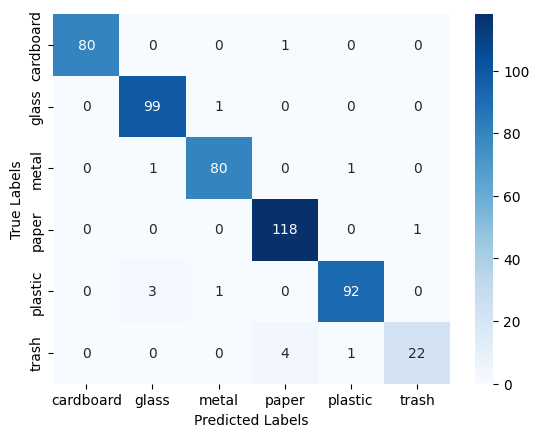

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = pd.DataFrame(
    confusion_matrix(
        final_outputs_df["labels"],
        final_outputs_df["preds"]
    ),
    id2label.values(),
    id2label.values()
)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

Based on the test set, the model is performing well with high true positive values along the diagonal, particularly for classes like "paper", "cardboard", and "glass". However, there are some misclassifications, especially for the "plastic" and "trash" classes. For example, the model incorrectly classifies some "trash" samples as "paper". This could be attributed to the class imbalance, as the "trash" class has relatively fewer samples in the original dataset. To improve performance, especially for the "trash" class, it would be beneficial to add more samples for this class. Despite these misclassifications, the overall performance of the model is solid, and the misclassifications are relatively low.